Python-AWIPS Tutorial Notebook

---


# Objectives

* Create a colorized plot with [Warnings, Watches, Advisories and Statements (WWAs)](https://weather.cod.edu/notes/criteria/)
* Use python-awips to connect to an EDEX server
* Create and filter the data request specifically for a warning data type
* Create and use accurate time filter for data requests
* Define and use functions
* Define and use dictionaries
* Colorize shapes based on a dictionary
* Overlay warnings, watches, and advisories with state and political maps

---

## Table of Contents

[1 Imports](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#imports)<br>  
[2 Function: make_map()](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#function-make-map)<br>  
[3 Function: get_color()](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#function-get-color)<br>  
[4 Function: get_title()](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#function-get-title)<br>  
[5 Initial Setup](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#initial-setup)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 EDEX Connection](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#edex-connection)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 Significance (Sig) Constants](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#significance-sig-constants)<br>  
[6 Filter by Time](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#filter-by-time)<br>  
[7 Use the Data!](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#use-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Get the Data](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#get-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.2 Extract Phensigs, Geometries, and Times](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#extract-phensigs-geometries-and-times)<br>  
[8 Plot the Data!](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#plot-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.1 Create State and Political Boundaries](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#create-state-and-political-boundaries)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.2 Draw the Plot and Legend for WWAs](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#draw-the-plot-and-legend-for-wwas)<br>  
[9 See Also](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#see-also)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[9.1 Related Notebooks](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#related-notebooks)<br>   
&nbsp;&nbsp;&nbsp;&nbsp;[9.2 Additional Documentation](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html#additional-documentation)<br>   

## 1 Imports

The imports below are used throughout the notebook.  The python-awips imports allow us to connect to an EDEX server, use the warning lookup dictionary, and define a TimeRange.  The additional imports are for data manipulation and visualization. 

In [1]:
from datetime import datetime, timedelta

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature, NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import MultiPolygon, Polygon

from awips.dataaccess import DataAccessLayer
from awips.tables import vtec
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 2 Function: make_map()

In order to plot more than one image, it's easiest to define common logic in a function. However, for this notebook we only use it in one place.  It is a function you will find in most of our example notebooks.

Here, a new function called **make_map** is defined.  This function uses the [matplotlib.pyplot package (plt)](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html) to create a figure and axis.  The lat/lon grids are added.

In [2]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 3 Function: get_color()

Since we'll be needing to access the color using the vtec lookup table in several places, creating an easily recognizable function is useful.

In [3]:
def get_color(phensig):
    return vtec[phensig]['color']

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 4 Function get_title()

Similar to the color function just defined, accessing the full name for the phensig will also be necessary, so this function will be helpful.

In [4]:
def get_title(phensig):
    return vtec[phensig]['hdln']

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 5 Initial Setup

### 5.1 EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***warning***, and set the Parameters to ***phensig*** and ***sig***.

<br>
<div class="alert-info">
<b>Note:</b> Remember, to see all available parameters use the <a href="http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getAvailableParameters"><b>DataAccess.getAvailableParameters()</b></a> method as shown in the <a href="http://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html#get-available-parameters"><b>Grid Levels and Parameters Notebook.</b></a>
</div>

In [5]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("warning")
params = ["phensig", "sig"]
request.setParameters(*(params))

### 5.2 Significance (Sig) Constants

The two parameters we're requesting for our warning objects are ***phensig*** and ***sig*** where phensig is styled "XX.Y" and sig is "Y".  Phen stands for "Phenomena" and sig stands for "Significance". [A more detailed description of phensigs and how they're used is provided with this NWS pamphlet](https://www.weather.gov/media/vtec/VTEC_explanation4-20.pdf).

The constants in this section correlate the ***sig*** to what type of message it is (what significance it is).

In [6]:
WATCH_SIG = 'A'
WARN_SIG = 'W'
ADVIS_SIG = 'Y'
STATEM_SIG = 'S'

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 6 Filter by Time

Here we decide how much data we want to pull from EDEX.  By default we'll request 12 hours, but that value can easily be modified by [adjusting the `timedelta(hours = 12)`](https://docs.python.org/3/library/datetime.html#timedelta-objects) in line `2`.  The more data we request, the longer the next section will take to run.

In [7]:
# Get records from the last 12 hours
lastHourDateTime = datetime.utcnow() - timedelta(hours = 12)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 7 Use the Data!

### 7.1 Get the Data

Now that we have our `request` and TimeRange `timerange` objects ready, it's time to request the data array from EDEX.

<br>
<div class="alert-info">
<b>Note:</b> Above we set <b>timerange</b> to be 12 hours worth of data.  This can return on the order of ~2000 records and can take a little while to run.
</div>

In [8]:
# Get response
response = DataAccessLayer.getGeometryData(request, timerange)
print("Using " + str(len(response)) + " records")

Using 1502 records


### 7.2 Extract Phensigs, Geometries, and Times

In this section we start gathering all the information we'll need to properly display our data.  First we create an array to keep track of unique phensigs.  This is useful summary information and will be used to help create the legend which we'll display along with our plot.

Next, we create arrays for each of the 4 types of significance a statement can have.  We will group our records this way, so we can easily toggle which records to display or not.

Then, we create two time variables to keep track of the earliest time from our records and the latest time, and will display that information in the title of our plot.

This section has optional print statements at lines `65` and `85`.  The first prints out the title, phensig, ref time, and shape for each unique phensig, and the second prints out a sum of how many unique phensigs there are.

We cycle through all the data produced from our `response` object, access its geometries, and create a new [**ShapelyFeature**](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.feature.ShapelyFeature.html) with the corresponding color.  Then we place this new feature in the appropriate `shapes` array.  During this process we also populate the phensigs array with all unique phensig entries.

Finally, after we're done looping through all the `response` data, we create a mapping of phensigs to their corresponding titles.  This will be used later to sort the legend alphabetically by titles (which differs from simply sorting by phensig).  Ex. *Blizzard Warning (BZ.W)* would come before *Areal Flood Advisory (FA.Y)* if we simply sorted by phensig.

In [9]:
# Keep track of unique phensigs, to use in legend
phensigs = []

# Sort the geometries based on their sig
watch_shapes = []
warning_shapes = []
advisory_shapes = []
statement_shapes = []

# Keep track of the earliest and latest reftime for title
# start with the first time from the first object in the response
time_str = str(response[0].getDataTime().getRefTime())
# truncate the decimal seconds for datetime parsing
time_str = time_str[:-4]
# convert to datetime object for easy comparison
first_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
last_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')

for ob in response:
    
    # get the geometry for the object
    poly = ob.getGeometry()
    # get the reftime for the object
    ref  = ob.getDataTime().getRefTime()
    
    # do not plot if phensig is blank (SPS)
    if ob.getString('phensig'):
        
        # look at the reftime
        # convert reftime to a string and parse the decimal seconds
        ref_str = str(ref)
        ref_str = ref_str[:-4]
        # convert reftime to a datetime object for comparison
        ref_time = datetime.strptime(ref_str, '%Y-%m-%d %H:%M:%S')
        # compare current time with first and last times and set if appropriate
        if ref_time is not None:
            if ref_time < first_time:
                first_time = ref_time
            elif ref_time > last_time:
                last_time = ref_time
        
        # get the phensig and sig values from object
        phensigString = ob.getString('phensig')
        sig = ob.getString('sig')

        # set the geometries based on whether it's a MultiPolygon or Polygon
        if poly.geom_type == 'MultiPolygon':
            geometries = np.array([])
            geometries = np.append(geometries,MultiPolygon(poly))
        else:
            geometries = np.array([])
            geometries = np.append(geometries,Polygon(poly))

        for geom in geometries:
            bounds = Polygon(geom)
            intersection = bounds.intersection
            geoms = (intersection(geom) for geom in geometries if bounds.intersects(geom))
    
        # Store the unique phensigs
        if not phensigString in phensigs:
            phensigs.append(phensigString)
            # Optional printout of unique Phensigs
#             print(get_title(phensigString) + " (" + phensigString + ")
            
        # get the corresponding color using the dictionary
        color = get_color(phensigString)
        # create a new shape feature for the object
        shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor=color, edgecolor=color)
        # store the shape feature in the correct array
        if sig is WARN_SIG:
            warning_shapes.append(shape_feature)
        elif sig is WATCH_SIG:
            watch_shapes.append(shape_feature)
        elif sig is ADVIS_SIG:
            advisory_shapes.append(shape_feature)
        elif sig is STATEM_SIG:
            statement_shapes.append(shape_feature)

# Optional printout for the number of unique phensigs
print(len(phensigs), " Unique Phensigs")

# Map phensigs to their titles (used for displaying alphabetically by
# title in legend)
phensig_titles = {}
for phensig in phensigs:
    key = get_title(phensig)
    phensig_titles[key] = phensig

14  Unique Phensigs


[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 8 Plot the Data!

### 8.1 Create State and Political Boundaries

Define the state and political boundaries that we'll use in our plot to give more of a frame of reference.  These objects are standard method calls in the [Cartopy Feature package, using the NaturalEarthFeature function](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html#cartopy.feature.NaturalEarthFeature).

In [10]:
# Define the state and political boundaries for the plot  
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
political_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

### 8.2 Draw the Plot and Legend for WWAs

Here is where we finally get ot draw something!  The very first few lines of this section are constants that we can manually "switch on and off" for what records we want displayed.  By default we have all significance types drawn.  If we want to "turn off" any of the significance records, simply set it's corresponding constant to false, and re-run this cell to see how that plot compares.

The next step involves creating the objects that are used to define the legend.  We use the `phensig_titles` dictionary to loop through all the phensigs in alphabetical (by title) order. Then, we compare if the phensig will be displayed or not based on the display constants from the previous lines.  If the significance will be drawn then we create a new [**Patch** object](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html#matplotlib.patches.Patch) of the corresponding color with the corresponding label and add it to our `handles` array.

After that we define our bounding box and create our new plot with its figure and axes.

Our next step is to create our Title for our plot.  We create a title based on the draw variables to accurately describe what is being drawn in our plot.  Here is where we use the first and last times defined in a previous cell.

Finally, we create and show our plot.  We add the title to the plot, add all the features to the axes, and add the legend as well.  

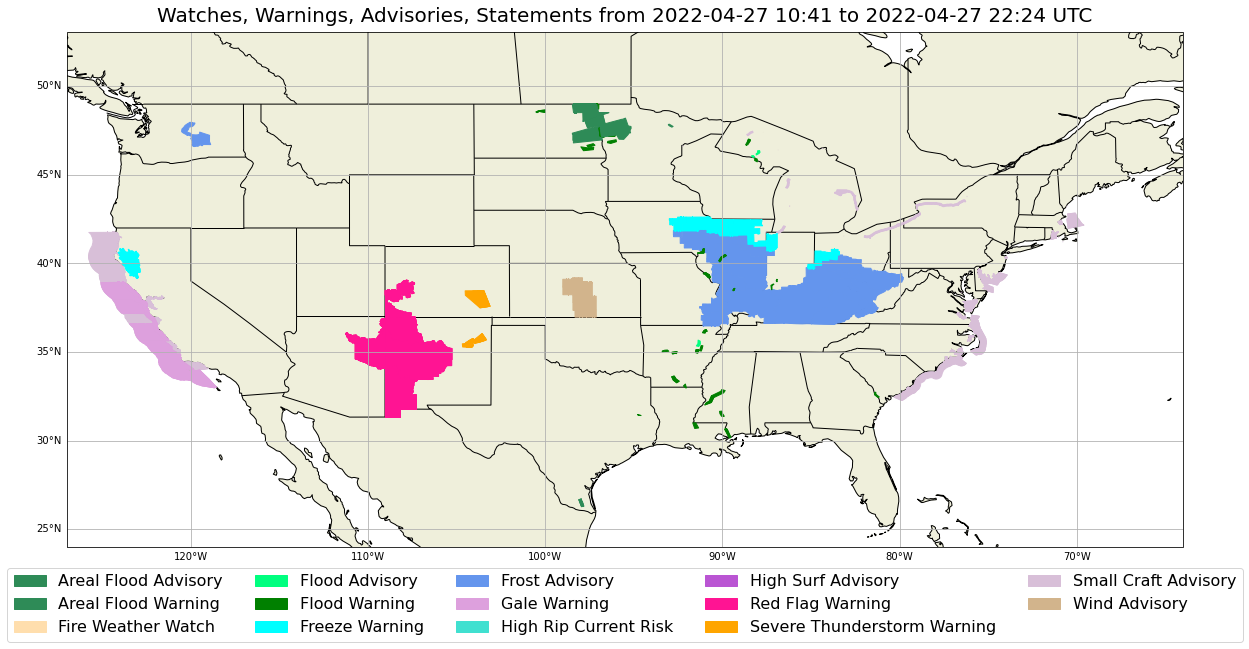

In [11]:
# Set these variables for which records to draw
DRAW_ADVISORY = True
DRAW_WATCH = True
DRAW_WARNING = True
DRAW_STATEMENT = True
    
# Create handles for legend and add items alphabetically by title and
# only display based on the display values above
handles = []
for title in sorted(phensig_titles):
    phensig = phensig_titles[title]
    # check draw booleans
    if ( "."+ADVIS_SIG in phensig and DRAW_ADVISORY or 
        "."+WATCH_SIG in phensig and DRAW_WATCH or 
        "."+WARN_SIG in phensig and DRAW_WARNING or 
        "."+STATEM_SIG in phensig and DRAW_STATEMENT ):
        entry = mpatches.Patch(color=get_color(phensig), label=title)
        handles.append(entry)

# Create the plot
bbox=[-127,-64,24,49]
fig, ax = make_map(bbox=bbox)

# Add the title
# Construct the title based on which record types are being displayed
title_string = ""
if DRAW_WATCH:
    title_string += "Watches, "
if DRAW_WARNING:
    title_string += "Warnings, "
if DRAW_ADVISORY:
    title_string += "Advisories, "
if DRAW_STATEMENT:
    title_string += "Statements, "
# remove the last comma and space
title_string = title_string[:-2]
# add the time range
title_string += " from " + str(first_time)[:-3] + " to " + str(last_time)[:-3] + " UTC"
# set the title on the plot, give it a bigger font size, and increase
# the vertical padding between the title and the figure
plt.title(title_string, fontsize=20, pad=10)

# Draw all features on the plot
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(political_boundaries, edgecolor='black')

# Draw WWAs in order: Advisory -> Watch > Warning > Statement
if DRAW_ADVISORY:
    for shape in advisory_shapes:
        ax.add_feature(shape)
if DRAW_WATCH:
    for shape in watch_shapes:
        ax.add_feature(shape)
if DRAW_WARNING:
    for shape in warning_shapes:
        ax.add_feature(shape)
if DRAW_STATEMENT:
    for shape in statement_shapes:
        ax.add_feature(shape)
    
# Draw the legend
# use the handles defined earlier for the color associations to
# phensig titles, set the location to the lower center, give it
# 5 columns so it uses all the horizonatal space, place it under
# the actual figure, and give it a larger fontsize
bottom = 0.12 + (len(handles)//5 *.04)
ax.legend(handles=handles, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -bottom), fontsize=16)

# Show the plot
plt.show()

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---

## 9 See Also

- [National Weather Service WWA Definitions (Baltimore Office)](https://www.weather.gov/lwx/warningsdefined#:~:text=A%20Winter%20Storm%20Warning%20is%20issued%20when%20a,combination%20of%20snow%20and%2For%20ice%20accumulation%20with%20wind.)
- [College of Dupage WWA Definitions](https://weather.cod.edu/notes/criteria/)
- [Phensig Explanation](https://www.weather.gov/media/vtec/VTEC_explanation4-20.pdf)

### 9.1 Related Notebooks

- [Grid Levels and Parameters](http://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)

### 9.2 Additional Documentation

**python-awips**

- [DataAccessLayer.changeEDEXHost()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.changeEDEXHost)
- [DataAccessLayer.newDataRequest()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.newDataRequest)
- [DataAccessLayer.getAvailableParameters()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getAvailableParameters)
- [IDataRequest](http://unidata.github.io/python-awips/api/IDataRequest.html)
- [GeometryData](http://unidata.github.io/python-awips/api/PyGeometryData.html)

**datetime**

- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects)
- [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects)

**cartopy**

- [cartopy feature interface](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html)
- [cartopy.feature.ShaeplyFeature](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.feature.ShapelyFeature.html)

**matplotlib**

- [matplotlib.pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
- [matplotlib.pyplot.legend()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)
- [matplotlib.pyplot.axes()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axes.html)
- [matplotlib.pyplot.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)
- [matplotlib.pyplot.title()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html)
- [matplotlib.pathes.Patch](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html#matplotlib.patches.Patch)

[Top](https://unidata.github.io/python-awips/examples/generated/Watch_Warning_and_Advisory_Plotting.html)

---